In [ ]:
#drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [ ]:
import os, pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

datadir = '/content/drive/MyDrive/Caseathon/unzipped_mscidata/data/classification_dataset'
labels_path = os.path.join(datadir, 'labels.txt')

# 1) Read labels & build absolute filepaths
df = pd.read_csv(labels_path, sep=r'\s+', header=None, names=['filename','label'])
df['filepath'] = df['filename'].apply(lambda x: os.path.join(datadir, 'images', str(x)))

# (optional) drop missing files robustly
df = df[df['filepath'].apply(os.path.exists)].reset_index(drop=True)

# 2) Map labels <str> -> <id>
class_names = sorted(df['label'].unique().tolist())
label2id = {c: i for i, c in enumerate(class_names)}
id2label = {i: c for c, i in label2id.items()}
df['label_id'] = df['label'].map(label2id).astype(int)
n_class = len(class_names)

# 3) Stratified split
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label_id']
)

# 4) Transforms (non-random for val)
train_tf = transforms.Compose([
    transforms.Resize(288),
    transforms.RandomResizedCrop(288, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize(288),
    transforms.CenterCrop(288),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# 5) Dataset
class LabeledImageDataset(Dataset):
    def __init__(self, frame, transform=None):
        self.df = frame.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    # def __getitem__(self, idx):
    #     row = self.df.iloc[idx]
    #     img = Image.open(row.filepath).convert('RGB')
    #     y = int(row.label_id)
    #     if self.transform: img = self.transform(img)
    #     return img, y
    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      img = Image.open(row.filepath).convert('RGB')
      y = int(row.label_id)
      if self.transform:
          img = self.transform(img)
      return {"pixel_values": img, "labels": y}


train_dataset = LabeledImageDataset(train_df, transform=train_tf)
val_dataset   = LabeledImageDataset(val_df,   transform=val_tf)

# 6) DataLoaders (deterministic val)
BATCH_SIZE = 32
NUM_WORKERS = 2  # set 0 on Google Drive if workers stall
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)

print(f"{len(train_dataset)=}, {len(val_dataset)=}, {n_class=}")
print(class_names)


len(train_dataset)=8400, len(val_dataset)=2100, n_class=7
['Eel', 'Scallop', 'crab', 'flatfish', 'roundfish', 'skate', 'whelk']


In [ ]:
print(id2label)

{0: 'Eel', 1: 'Scallop', 2: 'crab', 3: 'flatfish', 4: 'roundfish', 5: 'skate', 6: 'whelk'}


In [ ]:
from transformers import AutoImageProcessor
image_processor=AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")
from transformers import AutoModelForImageClassification

# model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
#                                                         id2label=id2label,
#                                                         label2id=label2id,
#                                                         ignore_mismatched_sizes=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
from tqdm.notebook import tqdm
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(10):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(train_loader)):
    # move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])

    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    optimizer.step()

    # metrics
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

Epoch: 0


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 1.9620596170425415
Accuracy after 0 steps: 0.09375
Loss after 100 steps: 0.9802889823913574
Accuracy after 100 steps: 0.5321782178217822
Loss after 200 steps: 1.0364406108856201
Accuracy after 200 steps: 0.6360385572139303
Epoch: 1


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.41396424174308777
Accuracy after 0 steps: 0.875
Loss after 100 steps: 0.6882263422012329
Accuracy after 100 steps: 0.8326113861386139
Loss after 200 steps: 0.22608627378940582
Accuracy after 200 steps: 0.8512126865671642
Epoch: 2


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.29102373123168945
Accuracy after 0 steps: 0.875
Loss after 100 steps: 0.6248763799667358
Accuracy after 100 steps: 0.8997524752475248
Loss after 200 steps: 0.39009541273117065
Accuracy after 200 steps: 0.9000310945273632
Epoch: 3


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.26124057173728943
Accuracy after 0 steps: 0.90625
Loss after 100 steps: 0.1477663367986679
Accuracy after 100 steps: 0.9204826732673267
Loss after 200 steps: 0.2444310039281845
Accuracy after 200 steps: 0.9227300995024875
Epoch: 4


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.2192889153957367
Accuracy after 0 steps: 0.90625
Loss after 100 steps: 0.22918370366096497
Accuracy after 100 steps: 0.9381188118811881
Loss after 200 steps: 0.2689667344093323
Accuracy after 200 steps: 0.9371890547263682
Epoch: 5


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.11145280301570892
Accuracy after 0 steps: 0.96875
Loss after 100 steps: 0.1810811460018158
Accuracy after 100 steps: 0.9492574257425742
Loss after 200 steps: 0.24341484904289246
Accuracy after 200 steps: 0.9465174129353234
Epoch: 6


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.30414140224456787
Accuracy after 0 steps: 0.90625
Loss after 100 steps: 0.03953742980957031
Accuracy after 100 steps: 0.9538985148514851
Loss after 200 steps: 0.02696153149008751
Accuracy after 200 steps: 0.9535136815920398
Epoch: 7


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.14816814661026
Accuracy after 0 steps: 0.96875
Loss after 100 steps: 0.14730867743492126
Accuracy after 100 steps: 0.9641089108910891
Loss after 200 steps: 0.08617871254682541
Accuracy after 200 steps: 0.9615982587064676
Epoch: 8


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.03350150212645531
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.10679110139608383
Accuracy after 100 steps: 0.9675123762376238
Loss after 200 steps: 0.031045209616422653
Accuracy after 200 steps: 0.9670398009950248
Epoch: 9


  0%|          | 0/263 [00:00<?, ?it/s]

Loss after 0 steps: 0.1476428210735321
Accuracy after 0 steps: 0.96875
Loss after 100 steps: 0.09388075023889542
Accuracy after 100 steps: 0.9662747524752475
Loss after 200 steps: 0.22101446986198425
Accuracy after 200 steps: 0.9675062189054726


In [ ]:
#save model to drive
torch.save(model.state_dict(), '/content/drive/MyDrive/Caseathon/weights/ConvNextmodel.pth')

In [ ]:
!pip install torchmetrics scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.2 MB/s eta 0:00:00


In [ ]:
@torch.inference_mode()
def evaluate(model, val_loader, criterion, device):
    was_training = model.training
    model.eval()

    total = 0
    correct = 0
    loss_sum = 0.0

    for batch in val_loader:
        # supports dict batches (HF-style)
        images = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        out = model(images)
        logits = out.logits if hasattr(out, "logits") else out  # HF or torchvision

        loss_sum += criterion(logits, labels).item() * images.size(0)
        correct  += (logits.argmax(1) == labels).sum().item()
        total    += labels.size(0)

    if was_training:
        model.train()

    return {"val_loss": loss_sum / total, "val_acc": correct / total}


In [ ]:

import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report
from typing import Optional, Dict

try:
    from torchmetrics.classification import ConfusionMatrix
    TM_AVAILABLE = True
except Exception:
    TM_AVAILABLE = False


@torch.inference_mode()
def evaluate_with_metrics(
    model,
    val_loader,
    device,
    criterion,
    n_classes: int,
    id2label: Optional[Dict[int, str]] = None,
    use_tta: bool = False,
    return_confmat: bool = False,
):
    """Evaluate model and compute per-class metrics. Optionally do TTA and return confusion matrix."""

    was_training = model.training
    model.eval()

    total = 0
    loss_sum = 0.0
    all_preds = []
    all_targets = []

    # torchmetrics confusion matrix (optional)
    cm = None
    if return_confmat and TM_AVAILABLE:
        cm = ConfusionMatrix(task="multiclass", num_classes=n_classes).to(device)

    for batch in val_loader:
        x = batch["pixel_values"].to(device, non_blocking=True)
        y = batch["labels"].to(device, non_blocking=True)

        # ---- TTA (identity + horizontal flip) ----
        if use_tta:
            # identity
            out0 = model(x)
            logits0 = out0.logits if hasattr(out0, "logits") else out0

            # hflip
            x_flip = torch.flip(x, dims=[-1])
            out1 = model(x_flip)
            logits1 = out1.logits if hasattr(out1, "logits") else out1

            logits = (logits0 + logits1) * 0.5
        else:
            out = model(x)
            logits = out.logits if hasattr(out, "logits") else out

        loss_sum += criterion(logits, y).item() * x.size(0)

        preds = logits.argmax(dim=1)
        all_preds.append(preds.detach().cpu())
        all_targets.append(y.detach().cpu())

        if cm is not None:
            cm.update(preds, y)

        total += y.size(0)

    # concatenate buffers
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # top-1 accuracy
    val_acc = (all_preds == all_targets).mean().item() if hasattr(val_acc := (all_preds == all_targets).mean(), "item") else (all_preds == all_targets).mean()

    # per-class report (precision/recall/f1 + support)
    target_names = [id2label[i] for i in range(n_classes)] if id2label else None
    report_str = classification_report(all_targets, all_preds, target_names=target_names, digits=4)

    # confusion matrix tensor (if requested)
    confmat_tensor = cm.compute().cpu().numpy() if cm is not None else None

    if was_training:
        model.train()

    return {
        "val_loss": loss_sum / total,
        "val_acc": float(val_acc),
        "report": report_str,
        "confusion_matrix": confmat_tensor,  # numpy array or None
    }


In [ ]:
val_loader

In [ ]:
from transformers import AutoModelForImageClassification
import torch
ckpt_path='/content/drive/MyDrive/Caseathon/weights/ConvNextmodel.pth'
import torch
from transformers import AutoConfig, ConvNextForImageClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Load your state dict
sd = torch.load(ckpt_path, map_location="cpu")

# If you saved under DDP, remove 'module.' prefix
if any(k.startswith("module.") for k in sd):
    sd = {k.replace("module.", "", 1): v for k, v in sd.items()}

# 2) Build the SAME variant with 7 classes
config = AutoConfig.from_pretrained("facebook/convnext-tiny-224")
config.num_labels = 7
model = ConvNextForImageClassification(config)

# 3) Strict load
missing, unexpected = model.load_state_dict(sd, strict=True)
print("Missing:", missing, "Unexpected:", unexpected)  # should both be []

model.to(device).eval()


Missing: [] Unexpected: []


ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm((96,), eps=1e-06, elementwise_affine=True)
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): ModuleList()
          (layers): ModuleList(
            (0-2): 3 x ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
          )
        )
        (1): ConvNextStage(
          (downsampling_layer): ModuleList(
          

In [ ]:
metrics=evaluate_with_metrics(model,val_loader,device,nn.CrossEntropyLoss(), n_class)
print(
        f"val_loss={metrics['val_loss']:.4f} | val_acc={metrics['val_acc']*100:.2f}%"
    )
print(metrics["report"])
print(metrics['confusion_matrix'])
#{0: 'Eel', 1: 'Scallop', 2: 'crab', 3: 'flatfish', 4: 'roundfish', 5: 'skate', 6: 'whelk'}



val_loss=0.2235 | val_acc=93.29%
              precision    recall  f1-score   support

           0     0.9771    0.9967    0.9868       300
           1     0.9161    0.9100    0.9130       300
           2     0.8935    0.9233    0.9082       300
           3     0.9352    0.9133    0.9241       300
           4     0.9155    0.9033    0.9094       300
           5     0.9866    0.9800    0.9833       300
           6     0.9064    0.9033    0.9048       300

    accuracy                         0.9329      2100
   macro avg     0.9329    0.9329    0.9328      2100
weighted avg     0.9329    0.9329    0.9328      2100

None


Actual label: Eel


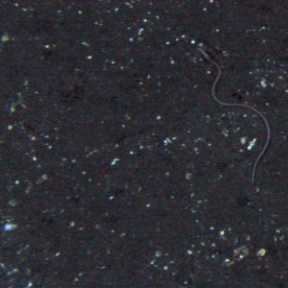

Predicted label: Eel


In [ ]:
# Get a sample from the training dataset
sample = train_dataset[0]
image = sample["pixel_values"]
label_id = sample["labels"]
actual_label = id2label[label_id]

# Display the image (need to reverse the normalization for display)
# The mean and std used for normalization were [0.485,0.456,0.406] and [0.229,0.224,0.225]
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
image_for_display = unnormalize(image)
image_for_display = transforms.ToPILImage()(image_for_display)

print(f"Actual label: {actual_label}")
display(image_for_display)

# Run inference on the image
model.eval()
with torch.no_grad():
    # Add a batch dimension to the image
    image_batch = image.unsqueeze(0).to(device)
    outputs = model(image_batch)
    logits = outputs.logits if hasattr(outputs, "logits") else outputs
    predicted_label_id = logits.argmax(dim=1).item()
    predicted_label = id2label[predicted_label_id]

print(f"Predicted label: {predicted_label}")

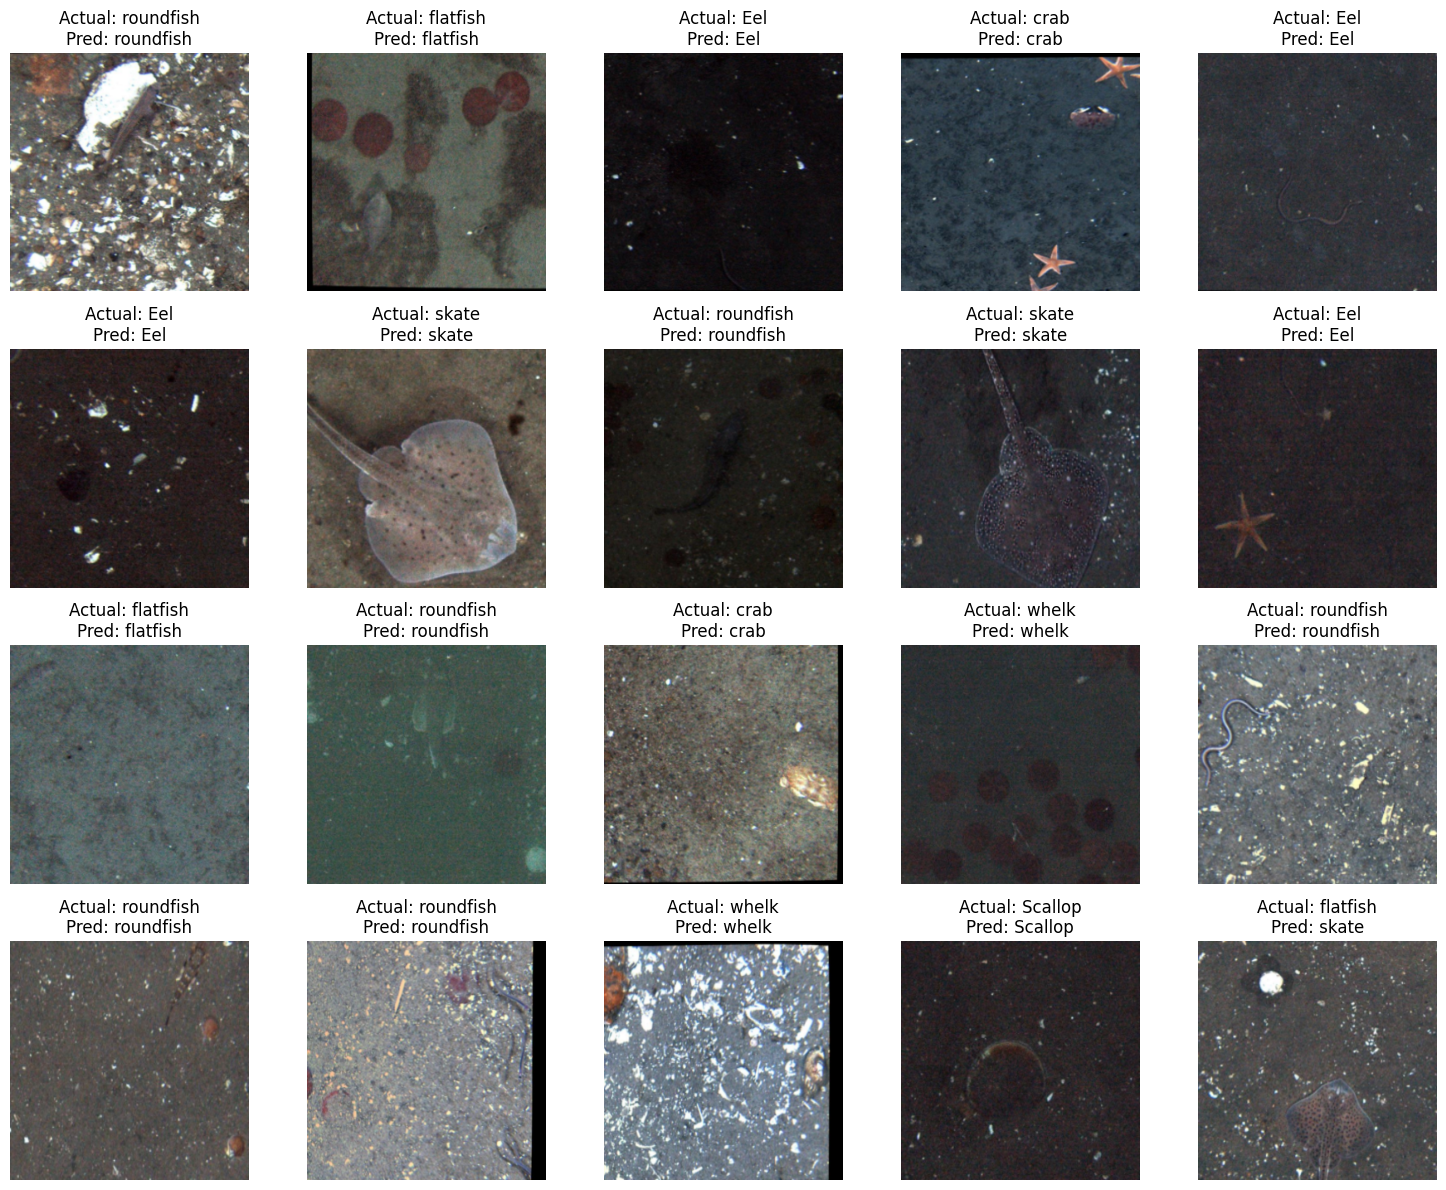

In [ ]:
import matplotlib.pyplot as plt
import math

# Function to unnormalize and display images
def unnormalize_and_display(image, mean, std):
    unnormalize = transforms.Normalize(
       mean=[-m/s for m, s in zip(mean, std)],
       std=[1/s for s in std]
    )
    image_for_display = unnormalize(image)
    image_for_display = transforms.ToPILImage()(image_for_display)
    return image_for_display

# Get a subset of the training dataset
num_images = 20
sample_indices = torch.randperm(len(train_dataset))[:num_images]

# Set up the plot grid
rows = math.ceil(num_images / 5)
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Run inference and display images
model.eval()
with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        # Convert the tensor index to an integer
        idx_int = idx.item()
        sample = train_dataset[idx_int]
        image = sample["pixel_values"]
        label_id = sample["labels"]
        actual_label = id2label[label_id]

        # Run inference on the image
        image_batch = image.unsqueeze(0).to(device)
        outputs = model(image_batch)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs
        predicted_label_id = logits.argmax(dim=1).item()
        predicted_label = id2label[predicted_label_id]

        # Unnormalize and display the image
        display_image = unnormalize_and_display(image, [0.485,0.456,0.406], [0.229,0.224,0.225])
        axes[i].imshow(display_image)
        axes[i].set_title(f"Actual: {actual_label}\nPred: {predicted_label}")
        axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()